In [1]:
# Author : https://github.com/boguss1225
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from utils.test_single_image import test_single_image_cv

os.environ["CUDA_VISIBLE_DEVICES"]="0"
# Colour Template (RGB)
RED = (255, 0, 0)
GREEN = (0, 255, 0)
BLUE = (0, 0, 255)
CYAN = (0, 255, 255)
MAGENTA = (255, 0, 255)
YELLOW = (255, 255, 0)

In [2]:
# TO BE CONFIGURED
PATCH_SIZE_W, PATCH_SIZE_H = 45, 45
NUM_CLASSES = 2
FILE_PATH = "../ivy_001.jpeg"
MODEL_PATH = "../ivy.keras"
image_size =45, 45

class_colour = {0:RED, 1:GREEN } # Strictly 2 classes are allowed. 
#if you want to classify more than 2 class, use "patch-base-classification-multi-class.ipynb"

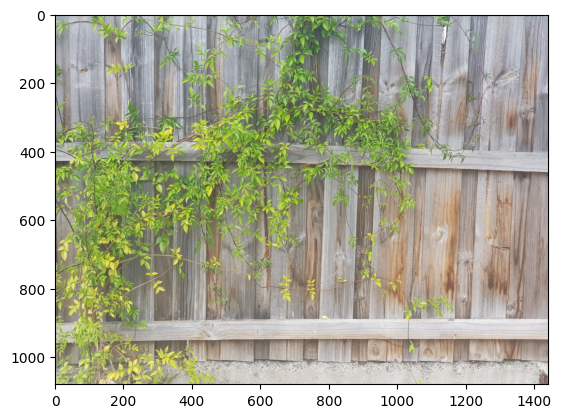

In [3]:
# Check image
img = mpimg.imread(FILE_PATH)
imgplot = plt.imshow(img)
plt.show()

In [4]:
"""
## Build a model
We'll build a small version of the Xception network. We haven't particularly tried to
optimize the architecture; if you want to do a systematic search for the best model
configuration, consider using
[KerasTuner](https://github.com/keras-team/keras-tuner).
Note that:
- We start the model with the `data_augmentation` preprocessor, followed by a
 `Rescaling` layer.
- We include a `Dropout` layer before the final classification layer.
"""


def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [5]:
# Load model
model_path = MODEL_PATH

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy", # add more metrics if you want
             tf.keras.metrics.AUC(),
             tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall()],
)

model.load_weights(model_path)
print("load weights successful -",model_path)

load weights successful - ../ivy.keras


In [6]:
# Load image
im = cv2.imread(FILE_PATH)
# im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
img_h, img_w, img_c = im.shape
print('width:  ', img_w)
print('height: ', img_h)
print('channel:', img_c)

width:   1440
height:  1080
channel: 3


In [7]:
# Initialize blank mask image of same dimensions for drawing the shapes
bg = np.zeros_like(im, np.uint8)

In [8]:
w_ratio = int(img_w/PATCH_SIZE_W)
h_ratio = int(img_h/PATCH_SIZE_H)

In [9]:
# Prepare for statistics
num_cls = NUM_CLASSES
result_stat = [0] * num_cls

In [31]:
# iterate image upto patch size
for h in range(h_ratio) :
    y_min = h * PATCH_SIZE_H
    y_max = y_min + PATCH_SIZE_H
    
    for w in range(w_ratio) : 
        x_min = w * PATCH_SIZE_W
        x_max = x_min + PATCH_SIZE_W
        
        # Cropping image
        cropped_image = im[y_min:y_max,x_min:x_max]
        
        # Classify cropped image
        classfication_result, prob = test_single_image_cv(cropped_image, model)
        if prob.numpy()[0][0] > 0.5:
            classfication_result = 1
            
        # Update statistics data
        result_stat[classfication_result] += 1
        
        # overlay colour on image 
        cv2.rectangle(bg, (x_min, y_min), (x_max, y_max), class_colour[classfication_result] ,cv2.FILLED)

In [32]:
# Generate output by blending image with bg image, using the bg
# images also as mask to limit the blending to those parts
out = im.copy()
alpha = 0.5 # transparant (highest : 1.0, lowest : 0)
mask = bg.astype(bool)
out[mask] = cv2.addWeighted(im, alpha, bg, 1 - alpha, 0)[mask]

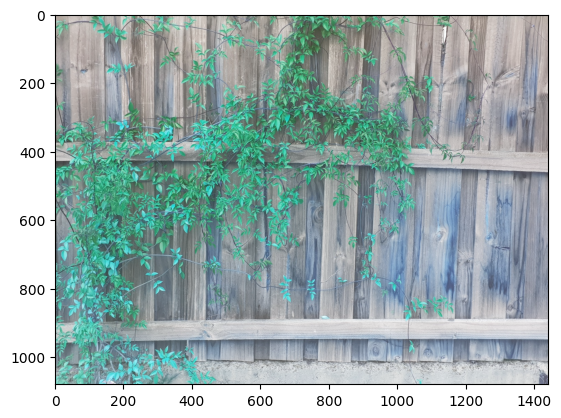

In [33]:
plt.imshow(im)

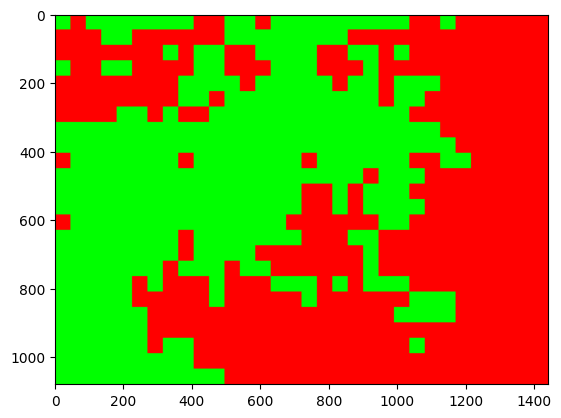

In [34]:
plt.imshow(bg)

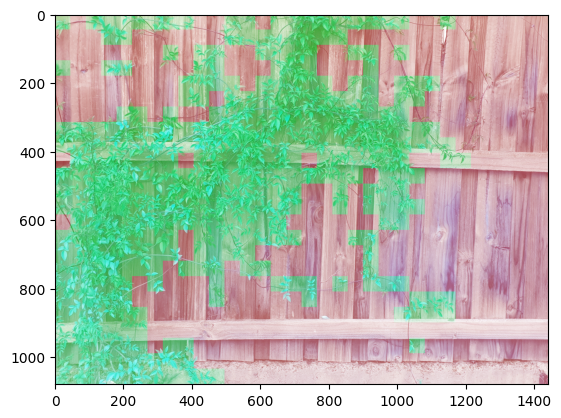

In [35]:
plt.imshow(out)

In [36]:
# Create summary table
from tabulate import tabulate

headers = ["item", "qty", "%"]
total = sum(result_stat)
table = []

for i in range(num_cls) :
    ele = ["cls_"+str(i+1),result_stat[i],round(result_stat[i]/total,3)*100]
    table.append(ele)

table_str = tabulate(table, headers, tablefmt="fancy_outline")
print(table_str)

╒════════╤═══════╤══════╕
│ item   │   qty │    % │
╞════════╪═══════╪══════╡
│ cls_1  │   410 │ 53.4 │
│ cls_2  │   358 │ 46.6 │
╘════════╧═══════╧══════╛
